<a href="https://colab.research.google.com/github/saitzaw/apache-spark-colab/blob/main/Spark_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Apache Spark 3.2.1 
- new spark version with java-8

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar -xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark

In [2]:
import os
import findspark
from pyarrow import parquet
from pyspark.sql import SparkSession

In [3]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [4]:
findspark.init()
spark = SparkSession.builder\
                    .master("local")\
                    .appName("colab")\
                    .config("spark.ui.port", "4050")\
                    .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
data_file = '/content/gdrive/MyDrive/ColabDataset/MotorVehicleCollisionsCrashes.parquet'

In [7]:
df = spark.read.parquet(data_file)

In [8]:
df.show(5, truncate=True, vertical=True)

-RECORD 0---------------------------------------------
 CRASH_DATE                    | 04/14/2021           
 CRASH_TIME                    | 5:32                 
 BOROUGH                       | null                 
 ZIP_CODE                      | null                 
 LATITUDE                      | null                 
 LONGITUDE                     | null                 
 LOCATION                      | null                 
 ON_STREET_NAME                | BRONX WHITESTONE ... 
 CROSS_STREET_NAME             | null                 
 OFF_STREET_NAME               | null                 
 NUMBER_OF_PERSONS_INJURED     | 0.0                  
 NUMBER_OF_PERSONS_KILLED      | 0.0                  
 NUMBER_OF_PEDESTRIANS_INJURED | 0                    
 NUMBER_OF_PEDESTRIANS_KILLED  | 0                    
 NUMBER_OF_CYCLIST_INJURED     | 0                    
 NUMBER_OF_CYCLIST_KILLED      | 0                    
 NUMBER_OF_MOTORIST_INJURED    | 0                    
 NUMBER_OF

In [9]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import date_format, when, col, to_date

In [11]:
ndf = df.select(
    date_format(
        to_date(col('CRASH_DATE'), 'dd/mm/yyyyy'),'dd-mm-yyyy'
        ).alias('date'))

In [12]:
def splitUDF(row):
    if "/" in row:
        mm,dd,yyyy = row.split("/")
    elif "-" in row:
        yyyy,mm,dd = row.split("-")

    return [yyyy,mm,dd]

In [13]:
datSplitterUDF = udf(lambda row : splitUDF(row),ArrayType(StringType()))

In [14]:
ndf = df\
.select('*', datSplitterUDF(df.CRASH_DATE).alias("dt"))\
.withColumn('year',col('dt').getItem(0).cast('int'))\
.withColumn('month',col('dt').getItem(1).cast('int'))\
.withColumn('day',col('dt').getItem(2).cast('int'))

In [15]:
ndf.show(5, truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------
 CRASH_DATE                    | 04/14/2021                               
 CRASH_TIME                    | 5:32                                     
 BOROUGH                       | null                                     
 ZIP_CODE                      | null                                     
 LATITUDE                      | null                                     
 LONGITUDE                     | null                                     
 LOCATION                      | null                                     
 ON_STREET_NAME                | BRONX WHITESTONE BRIDGE                  
 CROSS_STREET_NAME             | null                                     
 OFF_STREET_NAME               | null                                     
 NUMBER_OF_PERSONS_INJURED     | 0.0                                      
 NUMBER_OF_PERSONS_KILLED      | 0.0                                      
 NUMBER_OF_PEDESTRIANS_IN

In [16]:
drop_list = [
             'CRASH_DATE',
             'BOROUGH',
             'ZIP_CODE',
             'LOCATION',
             'ON_STREET_NAME',
             'CROSS_STREET_NAME',
             'OFF_STREET_NAME',
             'CONTRIBUTING_FACTOR_VEHICLE_1',
             'CONTRIBUTING_FACTOR_VEHICLE_2',
             'CONTRIBUTING_FACTOR_VEHICLE_3',
             'CONTRIBUTING_FACTOR_VEHICLE_4',
             'CONTRIBUTING_FACTOR_VEHICLE_5',
             'COLLISION_ID',
             'VEHICLE_TYPE_CODE_1',
             'VEHICLE_TYPE_CODE_2',
             'VEHICLE_TYPE_CODE_3',
             'VEHICLE_TYPE_CODE_4',
             'VEHICLE_TYPE_CODE_5',
             'dt'
             ]

In [17]:
slice_df = ndf.drop(*drop_list)

In [18]:
rm_na_loc_null = slice_df.filter(
    (df['LATITUDE'].isNotNull())
    &(df['LONGITUDE'].isNotNull()))

In [19]:
rename_df = rm_na_loc_null\
.withColumnRenamed("CRASH_TIME", "time")\
.withColumnRenamed("LATITUDE", "lat")\
.withColumnRenamed("LONGITUDE", "lon")\
.withColumnRenamed("NUMBER_OF_PERSONS_INJURED", "npi")\
.withColumnRenamed("NUMBER_OF_PERSONS_KILLED", "npk")\
.withColumnRenamed("NUMBER_OF_PEDESTRIANS_INJURED", "npedi")\
.withColumnRenamed("NUMBER_OF_PEDESTRIANS_KILLED", "npedk")\
.withColumnRenamed("NUMBER_OF_CYCLIST_INJURED", "nci")\
.withColumnRenamed("NUMBER_OF_CYCLIST_KILLED", "nck")\
.withColumnRenamed("NUMBER_OF_MOTORIST_INJURED", "nmi")\
.withColumnRenamed("NUMBER_OF_MOTORIST_KILLED", "nmk")

In [20]:
reorder_df = rename_df.select(
    "year", "month", "day",
    "time", "lat", "lon",
    "npi", "npk", "npedi",
    "npedk", "nci", "nck",
    "nmi", "nmk"
    )

In [21]:
reorder_df.show(3, truncate=False, vertical=True)

-RECORD 0----------
 year  | 2021      
 month | 4         
 day   | 13        
 time  | 21:35     
 lat   | 40.68358  
 lon   | -73.97617 
 npi   | 1.0       
 npk   | 0.0       
 npedi | 1         
 npedk | 0         
 nci   | 0         
 nck   | 0         
 nmi   | 0         
 nmk   | 0         
-RECORD 1----------
 year  | 2021      
 month | 4         
 day   | 12        
 time  | 8:25      
 lat   | 0.0       
 lon   | 0.0       
 npi   | 0.0       
 npk   | 0.0       
 npedi | 0         
 npedk | 0         
 nci   | 0         
 nck   | 0         
 nmi   | 0         
 nmk   | 0         
-RECORD 2----------
 year  | 2019      
 month | 5         
 day   | 21        
 time  | 22:50     
 lat   | 40.69754  
 lon   | -73.98312 
 npi   | 0.0       
 npk   | 0.0       
 npedi | 0         
 npedk | 0         
 nci   | 0         
 nck   | 0         
 nmi   | 0         
 nmk   | 0         
only showing top 3 rows



In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [35]:
df_20 = reorder_df.filter(reorder_df['year'] == 2020)

In [74]:
df_19 = reorder_df.filter(reorder_df['year'] == 2019)

In [75]:
df_21 = reorder_df.filter(reorder_df['year'] == 2021)

In [36]:
df_20.count()

103989

In [37]:
pd_df_20 = df_20.toPandas()

In [38]:
pd_df_20.head(5)

,year,month,day,time,lat,lon,npi,npk,npedi,npedk,nci,nck,nmi,nmk
0,2020,4,15,15:20,40.671585,-73.99843,0.0,0.0,0,0,0,0,0,0
1,2020,4,17,1:50,40.771610,-73.99046,1.0,0.0,0,0,0,0,1,0
2,2020,9,6,18:05,40.771038,-73.83413,0.0,1.0,0,0,0,0,0,1
3,2020,4,21,16:40,40.877796,-73.86806,0.0,0.0,0,0,0,0,0,0
4,2020,5,2,17:30,40.673760,-73.79473,0.0,0.0,0,0,0,0,0,0


In [47]:
pd_df_20[['npi', 'npk']].describe()

,npi,npk
count,103989.000000,103989.000000
mean,0.390936,0.002289
std,0.741690,0.051280
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,15.000000,4.000000


In [49]:
import numpy as np
np.unique(pd_df_20['npi'].to_list())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 15.])

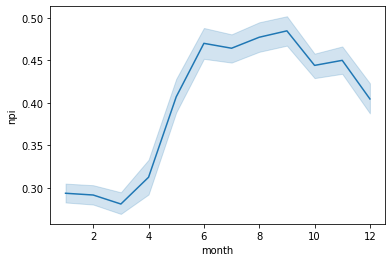

In [67]:
sns.lineplot(x="month", y="npi", data=pd_df_20)


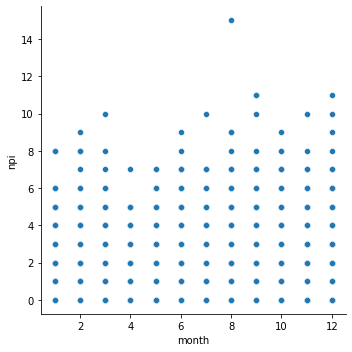

In [68]:
sns.relplot(x="month", y="npi", data=pd_df_20)

In [53]:
pd_df_20_jan =  pd_df_20.loc[pd_df_20['month'] == 1]

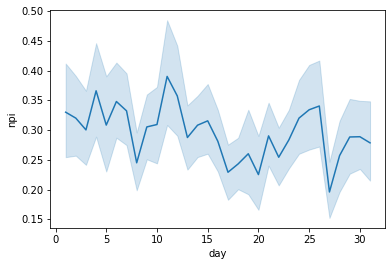

In [54]:
sns.lineplot(data=pd_df_20_jan, x="day", y="npi")

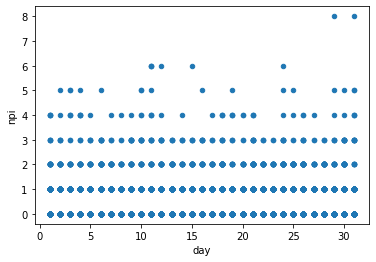

In [57]:
pd_df_20_jan.plot.scatter(x="day", y="npi")

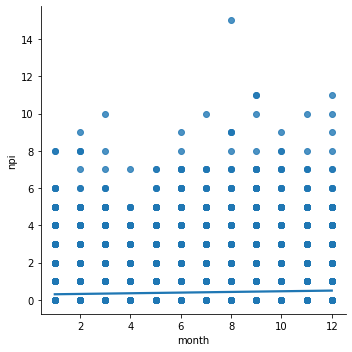

In [58]:
sns.lmplot(x="month", y="npi", data=pd_df_20)

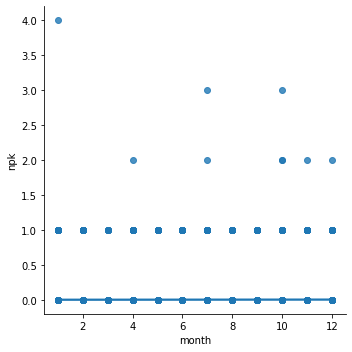

In [59]:
sns.lmplot(x="month", y="npk", data=pd_df_20)

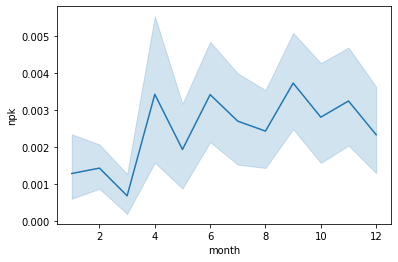

In [45]:
sns.lineplot(data=pd_df_20, x="month", y="npk")

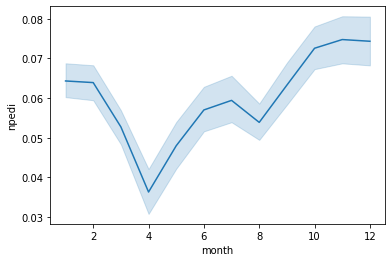

In [60]:
sns.lineplot(data=pd_df_20, x="month", y="npedi")

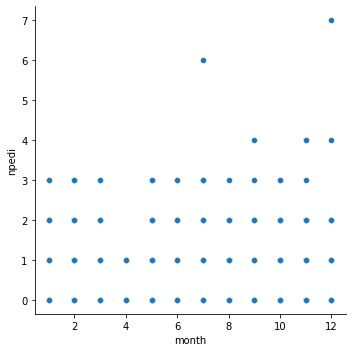

In [69]:
sns.relplot(data=pd_df_20, x="month", y="npedi")

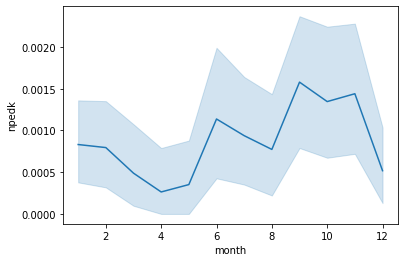

In [61]:
sns.lineplot(data=pd_df_20, x="month", y="npedk")

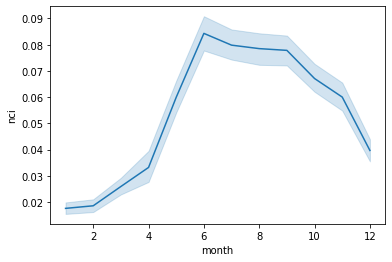

In [62]:
sns.lineplot(data=pd_df_20, x="month", y="nci")

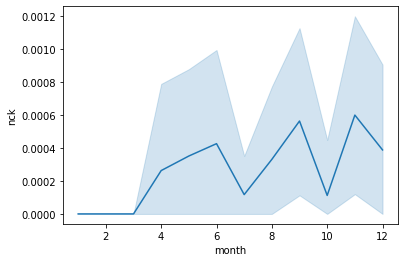

In [63]:
sns.lineplot(data=pd_df_20, x="month", y="nck")

In [76]:
pd_df_21 = df_21.toPandas()

In [77]:
pd_df_21.head(5)

,year,month,day,time,lat,lon,npi,npk,npedi,npedk,nci,nck,nmi,nmk
0,2021,4,13,21:35,40.683580,-73.976170,1.0,0.0,1,0,0,0,0,0
1,2021,4,12,8:25,0.000000,0.000000,0.0,0.0,0,0,0,0,0,0
2,2021,2,26,14:50,40.843464,-73.836000,0.0,0.0,0,0,0,0,0,0
3,2021,3,9,11:00,40.692547,-73.990974,1.0,0.0,0,0,0,0,1,0
4,2021,3,31,22:20,40.626457,-73.918000,1.0,0.0,0,0,0,0,1,0


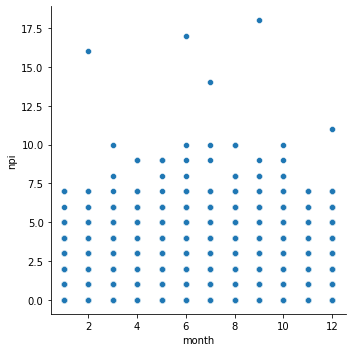

In [78]:
sns.relplot(x="month", y="npi", data=pd_df_21)

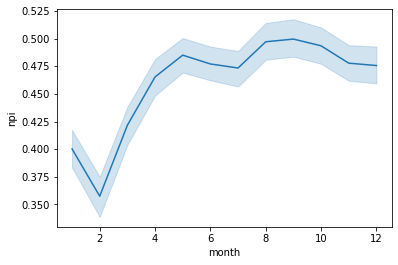

In [79]:
sns.lineplot(data=pd_df_21, x="month", y="npi")

In [82]:
pd_df_21.loc[pd_df_21['npi'] > 17]

,year,month,day,time,lat,lon,npi,npk,npedi,npedk,nci,nck,nmi,nmk
72000,2021,9,4,14:45,40.62551,-74.07599,18.0,0.0,0,0,0,0,18,0


In [94]:
pd_df_21_npi_loc = pd_df_21.loc[pd_df_21['npi'] == 18]

In [96]:
pd_df_21_npi_loc['lat']

72000    40.62551
Name: lat, dtype: float64

In [87]:
import folium

In [99]:
max_npi_loc = folium.Map(location=[40.62551, -74.07599], zoom_start=20)
tooltip = "Highest number of persion injured"
marker = folium.CircleMarker(
    location=[40.62551, -74.07599],
    radius=50,
    popup="Highest NPI",
    color="#3186cc",
    fill=True,
    fill_color="#3186cc"
    )
marker.add_to(max_npi_loc)

In [100]:
max_npi_loc